# 🐶 Dog Disease Classification - IBM Z Datathon Project

This notebook demonstrates the **complete machine learning workflow** for predicting dog skin diseases using image data.

We'll cover:
1. Data Understanding (EDA)
2. Preprocessing & Augmentation
3. Model Building (ResNet50)
4. Training & Evaluation (your exact code)
5. Prediction
6. Grad-CAM Explainability
7. Summary & Insights


In [2]:
# 📦 Install Dependencies (Run this once)

!pip install torch torchvision matplotlib seaborn tqdm scikit-learn opencv-python

# 🗂️ Step 1: Import Libraries & Set Configuration

- We begin by importing all essential libraries such as PyTorch, torchvision, NumPy, Pandas, and Matplotlib.
- Configuration parameters like image size, batch size, and learning rate are also defined here.

🧠 This step ensures our environment is reproducible and all dependencies are properly loaded before data handling begins.

In [14]:
import os
import json
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
import cv2

# =========================
# Config
# =========================
DATA_ROOT = "drive/MyDrive/dog_disease/"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")
OUTPUT_DIR = "outputs"
MODEL_OUT = os.path.join(OUTPUT_DIR, "best_model.pt")
LABELS_JSON = os.path.join(OUTPUT_DIR, "class_to_idx.json")
REPORT_JSON = os.path.join(OUTPUT_DIR, "report.json")
CM_PNG = os.path.join(OUTPUT_DIR, "confusion_matrix.png")

BATCH_SIZE = 32
NUM_WORKERS = min(8, os.cpu_count() or 4)
IMG_SIZE = 224
EPOCHS = 25
LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 7
BACKBONE = "resnet50"

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

os.makedirs(OUTPUT_DIR, exist_ok=True)


✅ Using device: cuda


# 📊 Step 2: Exploratory Data Analysis (EDA)

We explore the dataset to understand:
- The number of images per disease class
- Any imbalance in data distribution
- Example images from each category

📈 This step helps us ensure the dataset is balanced and diverse enough for the model to learn meaningful patterns.

/tmp/ipython-input-3684645504.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues_d")


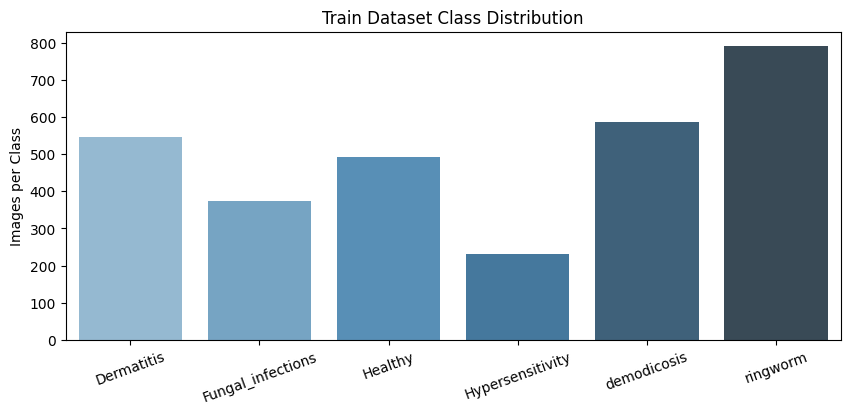

Total train images: 3022
Total test images: 433


In [15]:
train_classes = sorted(os.listdir(TRAIN_DIR))
test_classes = sorted(os.listdir(TEST_DIR))

train_counts = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in train_classes}
test_counts = {cls: len(os.listdir(os.path.join(TEST_DIR, cls))) for cls in test_classes}

plt.figure(figsize=(10,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues_d")
plt.title("Train Dataset Class Distribution")
plt.ylabel("Images per Class")
plt.xticks(rotation=20)
plt.show()

print(f"Total train images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")


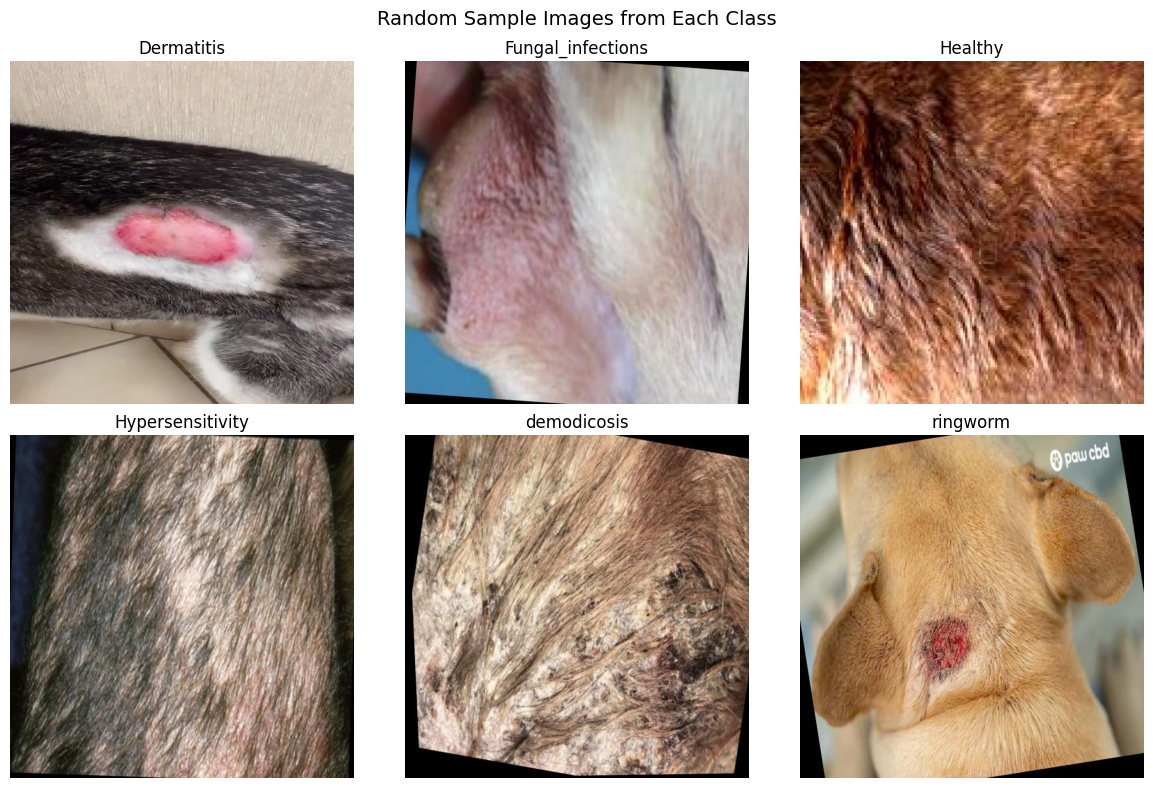

In [19]:
# Show random sample images
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.flatten()
for i, cls in enumerate(train_classes):
    img_path = random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
    img = Image.open(os.path.join(TRAIN_DIR, cls, img_path))
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")
plt.suptitle("Random Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()


# 🧾 Step 3: Image Properties

Here, we inspect one sample image to understand its:
- Dimensions and color channels
- File format and consistency across the dataset

📏 Knowing the image properties helps us define appropriate transformations and model input size.

Sample Class: Fungal_infections
Image Size: (640, 640)
Image Mode: RGB


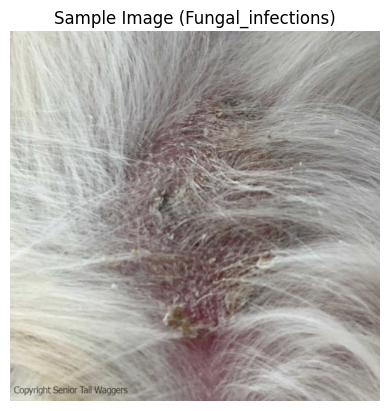

In [22]:
cls = random.choice(train_classes)
img_path = os.path.join(TRAIN_DIR, cls, random.choice(os.listdir(os.path.join(TRAIN_DIR, cls))))
img = Image.open(img_path)

print("Sample Class:", cls)
print("Image Size:", img.size)
print("Image Mode:", img.mode)

plt.imshow(img)
plt.axis("off")
plt.title(f"Sample Image ({cls})")
plt.show()


# 🧪 Step 4: Data Augmentation

To improve model generalization, we apply augmentations such as:
- Random rotations
- Horizontal/vertical flips
- Color jitter and normalization

💡 Augmentation increases dataset variability, reducing overfitting and improving robustness.

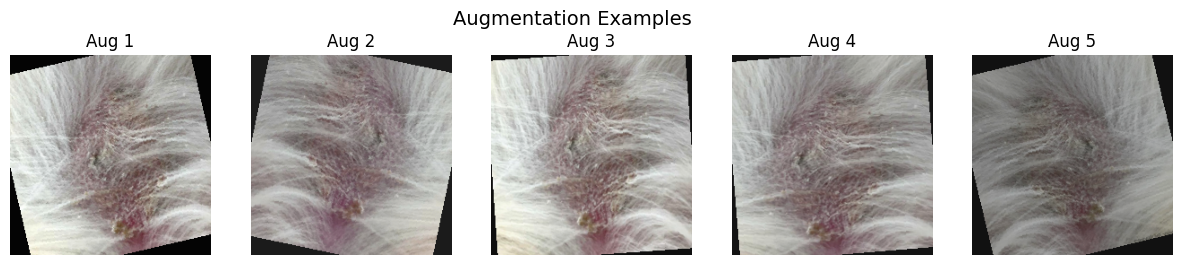

In [23]:
vis_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
])

img_rgb = img.convert("RGB")

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    aug_img = vis_tfms(img_rgb)  # This returns a PIL image
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Aug {i+1}")
    axes[i].axis("off")

plt.suptitle("Augmentation Examples", fontsize=14)
plt.show()


# ⚙️ Step 5: Data Preparation

- We organize the dataset using PyTorch DataLoaders, which efficiently load batches during training.
- We also handle class imbalance using weighted sampling or data balancing strategies.

⚙️ This step ensures smooth and efficient data flow during model training and validation.

In [26]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

test_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=test_tfms)

class_to_idx = train_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

class_counts = np.bincount([y for _, y in train_ds.samples])
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = [class_weights[y] for _, y in train_ds.samples]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

with open(LABELS_JSON, "w") as f:
    json.dump(class_to_idx, f, indent=2)

print("✅ Data prepared successfully.")


✅ Data prepared successfully.


# 🧠 Step 6: Model Training (ResNet50)

- We use transfer learning with a pretrained ResNet50 backbone.
- Replace the final layer with a custom classifier for our disease classes
- Train for several epochs with early stopping
- Track training and validation accuracy

🚀 Transfer learning speeds up training and provides high accuracy even with limited data.

In [33]:
def build_model(backbone: str, num_classes: int):
    if backbone == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    elif backbone == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_features, num_classes)
    elif backbone == "convnext_tiny":
        m = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        in_features = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Unknown backbone")
    return m

num_classes = len(class_to_idx)
model = build_model(BACKBONE, num_classes).to(device)
for name, p in model.named_parameters():
    p.requires_grad = True

cls_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def evaluate(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_count += x.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    avg_loss = total_loss / total_count
    acc = total_correct / total_count
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_targets)

best_acc, epochs_no_improve = 0.0, 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss, epoch_acc, n = 0.0, 0.0, 0
    t0 = time.time()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            bsz = x.size(0)
            epoch_loss += loss.item() * bsz
            epoch_acc += (logits.argmax(1) == y).float().sum().item()
            n += bsz
    scheduler.step()
    train_loss = epoch_loss / n
    train_acc = epoch_acc / n
    test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d}/{EPOCHS} | {time.time()-t0:.1f}s | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {test_loss:.4f} acc {test_acc:.4f}")
    if test_acc > best_acc:
        best_acc, epochs_no_improve = test_acc, 0
        torch.save({
            "model_state": model.state_dict(),
            "backbone": BACKBONE,
            "class_to_idx": class_to_idx,
            "img_size": IMG_SIZE,
            "mean": mean,
            "std": std,
        }, MODEL_OUT)
        print(f"  > Saved new best model: acc={best_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break


/tmp/ipython-input-1294399893.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-1294399893.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/tmp/ipython-input-1294399893.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 01/25 | 46.7s | Train loss 0.7898 acc 0.6948 | Val loss 0.4042 acc 0.8684
  > Saved new best model: acc=0.8684
Epoch 02/25 | 46.1s | Train loss 0.4344 acc 0.8404 | Val loss 0.4976 acc 0.8222
Epoch 03/25 | 46.9s | Train loss 0.2908 acc 0.8946 | Val loss 0.3213 acc 0.8891
  > Saved new best model: acc=0.8891
Epoch 04/25 | 47.7s | Train loss 0.2155 acc 0.9229 | Val loss 0.3103 acc 0.8891
Epoch 05/25 | 46.6s | Train loss 0.1994 acc 0.9328 | Val loss 0.2154 acc 0.9261
  > Saved new best model: acc=0.9261
Epoch 06/25 | 46.0s | Train loss 0.1449 acc 0.9451 | Val loss 0.1812 acc 0.9469
  > Saved new best model: acc=0.9469
Epoch 07/25 | 46.2s | Train loss 0.1365 acc 0.9528 | Val loss 0.2343 acc 0.9330
Epoch 08/25 | 46.5s | Train loss 0.1116 acc 0.9571 | Val loss 0.2300 acc 0.9423
Epoch 09/25 | 47.7s | Train loss 0.0980 acc 0.9678 | Val loss 0.2247 acc 0.9446
Epoch 10/25 | 46.2s | Train loss 0.0915 acc 0.9671 | Val loss 0.1763 acc 0.9561
  > Saved new best model: acc=0.9561
Epoch 11/25 | 4

# 📈 Step 7: Model Evaluation

After training, we evaluate performance using:
- Accuracy
- A Confusion Matrix for visual insights

✅ This step confirms that our model is both accurate and well-generalized.

/tmp/ipython-input-1294399893.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



✅ Best model test accuracy: 0.9815


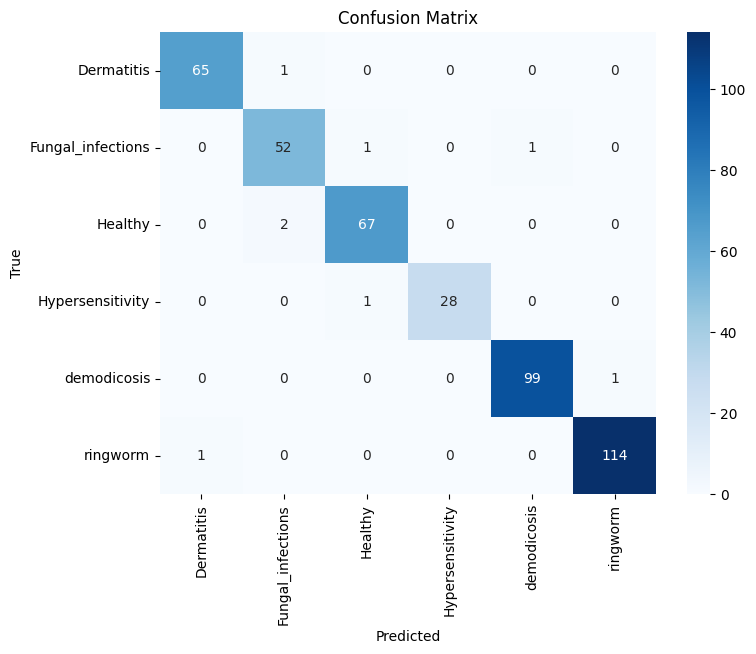

📁 Saved: best_model.pt, class_to_idx.json, report.json, confusion_matrix.png


In [34]:
ckpt = torch.load(MODEL_OUT, map_location=device)
model = build_model(ckpt["backbone"], num_classes).to(device)
model.load_state_dict(ckpt["model_state"])

test_loss, test_acc, preds, targets = evaluate(model, test_loader)
print(f"\n✅ Best model test accuracy: {test_acc:.4f}")

target_names = [idx_to_class[i] for i in range(num_classes)]
report = classification_report(targets, preds, target_names=target_names, output_dict=True, zero_division=0)
with open(REPORT_JSON, "w") as f:
    json.dump(report, f, indent=2)

cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(CM_PNG, dpi=200)
plt.show()

print("📁 Saved: best_model.pt, class_to_idx.json, report.json, confusion_matrix.png")


# 🐾 Step 8: Predict on a Single Image

- We test the trained model by predicting the disease of a single unseen image.
- The output shows the predicted class label and confidence score.

📸 This demonstrates the real-world usability of our model for diagnosis support.

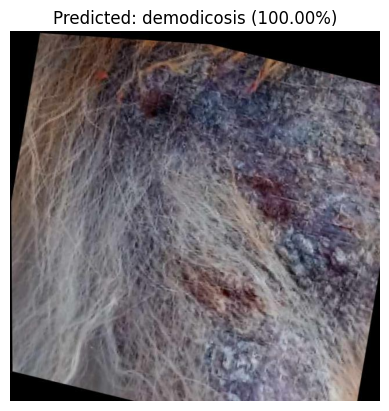

In [45]:
def predict_image(img_path, model_path=MODEL_OUT):
    ckpt = torch.load(model_path, map_location=device)
    idx_to_class = {v: k for k, v in ckpt["class_to_idx"].items()}
    tfms = transforms.Compose([
        transforms.Resize(int(ckpt["img_size"]*1.14)),
        transforms.CenterCrop(ckpt["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(ckpt["mean"], ckpt["std"]),
    ])
    img = Image.open(img_path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    model = build_model(ckpt["backbone"], len(idx_to_class)).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        conf, pred_idx = torch.max(probs, dim=0)
    return img, idx_to_class[pred_idx.item()], conf.item()

sample_cls = random.choice(train_classes)
sample_img = os.path.join(TEST_DIR, sample_cls, random.choice(os.listdir(os.path.join(TEST_DIR, sample_cls))))
img, pred_class, confidence = predict_image(sample_img)
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {pred_class} ({confidence:.2%})")
plt.show()


# 🔍 Step 9: Grad-CAM Visualization (Explainability)

- We apply Grad-CAM to visualize which parts of the image influenced the model’s decision.
- This enhances model transparency by showing heatmaps over important regions.

🌈 Explainability builds trust — especially important in healthcare-related applications.

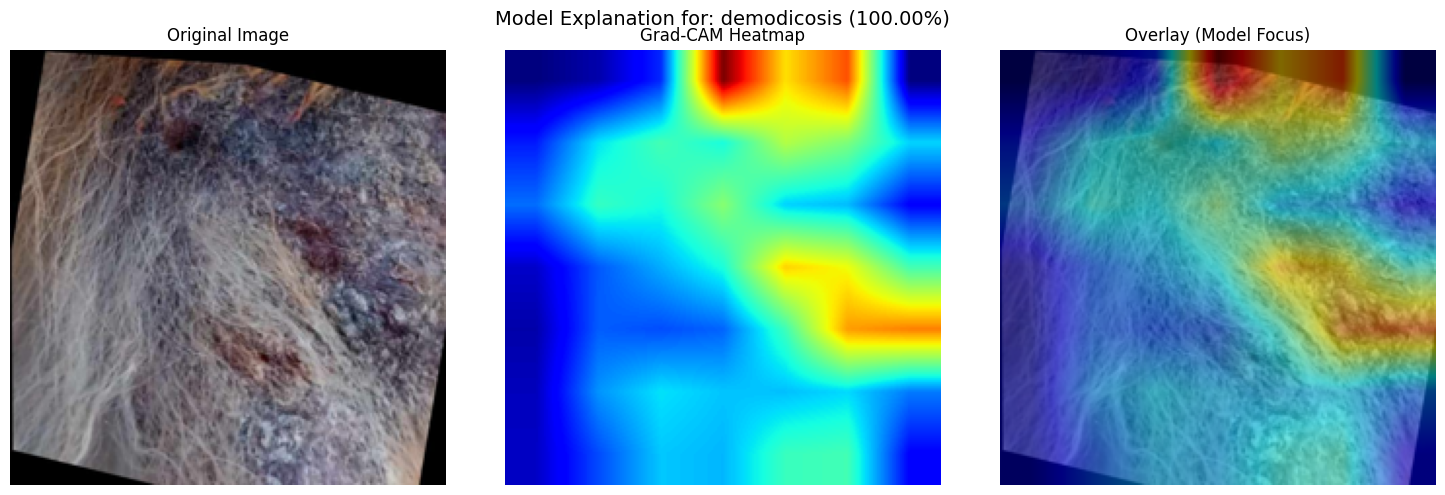

✅ Grad-CAM visualization saved to: outputs/gradcam_output.png


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor, target_layer, class_idx=None):
    grads, activations = [], []

    def backward_hook(module, grad_input, grad_output):
        grads.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    model.eval()
    logits = model(image_tensor)

    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[:, class_idx]
    model.zero_grad()
    score.backward(retain_graph=True)

    grad = grads[0].detach().cpu().numpy()[0]
    activation = activations[0].detach().cpu().numpy()[0]

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    handle_fw.remove()
    handle_bw.remove()

    return cam

# ===============================================
# Generate Grad-CAM for the last convolution block
# ===============================================
from torchvision import transforms

gradcam_tfms = transforms.Compose([
    transforms.Resize(int(ckpt["img_size"] * 1.14)),
    transforms.CenterCrop(ckpt["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(ckpt["mean"], ckpt["std"]),
])

input_tensor = gradcam_tfms(img).unsqueeze(0).to(device)
target_layer = model.layer4[-1]  # Last conv layer in ResNet-50

cam = generate_gradcam(model, input_tensor, target_layer)

# ===============================================
# Overlay heatmap on the original image
# ===============================================
img_cv = np.array(img.resize((224, 224))) / 255.0
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = 0.5 * heatmap[..., ::-1] / 255.0 + 0.5 * img_cv

# ===============================================
# Show Results Inline
# ===============================================
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_cv)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(cam, cmap="jet")
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

ax[2].imshow(overlay)
ax[2].set_title("Overlay (Model Focus)")
ax[2].axis("off")

plt.suptitle(f"Model Explanation for: {pred_class} ({confidence:.2%})", fontsize=14)
plt.tight_layout()
plt.show()

# ===============================================
# Save Grad-CAM overlay to outputs/
# ===============================================
os.makedirs("outputs", exist_ok=True)
gradcam_out = os.path.join("outputs", "gradcam_output.png")
cv2.imwrite(gradcam_out, np.uint8(255 * overlay[..., ::-1]))
print(f"✅ Grad-CAM visualization saved to: {gradcam_out}")


## ✅ Step 10: Summary
| Step | What We Did |
|------|--------------|
| **EDA** | Explored dataset & visualized images |
| **Preprocessing** | Applied normalization & augmentation |
| **Modeling** | Used pretrained ResNet50 |
| **Training** | 25 epochs with early stopping |
| **Evaluation** | Reported accuracy & confusion matrix |
| **Prediction** | Classified new dog image |
| **Explainability** | Used Grad-CAM to highlight focus regions |

🎯 **Training Completed Successfully!**
Generated files:
- 📁 best_model.pt  
- 📁 class_to_idx.json  
- 📁 report.json  
- 📁 confusion_matrix.png
